In [1]:
import sys
import os
import requests
import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.client import device_lib
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras_visualizer import visualizer
from IPython.display import display, Image

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)

2025-10-16 13:08:50.214304: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-16 13:08:50.288215: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-16 13:08:50.290484: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-16 13:08:51.348497: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import sys
import requests
import importlib

def import_local_or_github(package_name, function_name=None, directory=None, giturl=None):
    # Import functions directly from github
    # Important: note that we use raw.githubusercontent.com, not github.com

    try: # to find the file locally
        if directory is not None:
            if directory not in sys.path:
                sys.path.append(directory)

        package = importlib.import_module(package_name)
        if function_name is not None:
            function = getattr(package, function_name)
            return function
        else:
            return package

    except: # get the file from github
        if giturl is None:
            giturl = 'https://raw.githubusercontent.com/florisvb/Nonlinear_and_Data_Driven_Estimation/main/Utility/' + str(package_name) + '.py'

        r = requests.get(giturl)
        print('Fetching from: ')
        print(r)

        # Store the file to the colab working directory
        with open(package_name+'.py', 'w') as f:
            f.write(r.text)
        f.close()

        # import the function we want from that file
        package = importlib.import_module(package_name)
        if function_name is not None:
            function = getattr(package , function_name)
            return function
        else:
            return package

planar_drone = import_local_or_github('planar_drone', directory='../Utility')
plot_tme = import_local_or_github('plot_utility', 'plot_tme', directory='../Utility')
generate_training_data_utility = import_local_or_github('generate_training_data_utility', directory='../Utility')
keras_ann_utility = import_local_or_github('keras_ann_utility', directory='../Utility')
keras_advanced_utility = import_local_or_github('keras_advanced_utility', directory='../Utility')

/home/caveman/PY38/lib/python3.8/site-packages/do_mpc/sysid/__init__.py:15: UserWarning: The ONNX feature is not available. Please install the full version of do-mpc to access this feature.
  warnings.warn('The ONNX feature is not available. Please install the full version of do-mpc to access this feature.')
/home/caveman/PY38/lib/python3.8/site-packages/do_mpc/opcua/__init__.py:14: UserWarning: The opcua feature is not available. Please install the full version of do-mpc to access this feature.
  warnings.warn('The opcua feature is not available. Please install the full version of do-mpc to access this feature.')


# Download, load, clean, and add noise to data as in Lesson 12.A

In [3]:
generate_training_data_utility.download_data('planar_drone_trajectories.zip')

Fetching from: https://raw.githubusercontent.com/florisvb/Nonlinear_and_Data_Driven_Estimation/main/Data/planar_drone_trajectories.zip
Successfully downloaded planar_drone_trajectories.zip (29316396 bytes)
unzipping...


In [4]:
traj_list = generate_training_data_utility.load_trajectory_data('planar_drone_trajectories')

Number of trajectories: 
3001


In [5]:
traj_list = generate_training_data_utility.clean_trajectory_data(traj_list)

Number of good trajectories: 
2924


In [6]:
traj_list = generate_training_data_utility.add_noise_to_trajectory_data(traj_list, 0.02)

# Get derivatives

In [7]:
state_names =  ['theta', 'theta_dot', 'x', 'x_dot', 'z', 'z_dot'] 

In [8]:
import pynumdiff

In [9]:
for i, traj in enumerate(traj_list):
    for state in state_names:
        state_smooth, ddt_state = pynumdiff.savgoldiff(traj[state], 0.1, degree=3, window_size=5, smoothing_win=5)
        traj['ddt_' + state] = ddt_state
    traj_list[i] = traj

# Build augmented data frames

This demo shows how to include an auxiliary time delay embedding. If you dynamics truly are given by:

$$
\dot{\mathbf{x}} = \mathbf{f}(\mathbf{x}, \mathbf{u})
$$

Then this is uneccessary. But if your dynamics contain hysteresis you may need this functionality. 

In [10]:
state_names =  ['theta', 'theta_dot', 'x', 'x_dot', 'z', 'z_dot'] 
control_names = ['j1', 'j2']
output_names = ['ddt_' + state for state in state_names] #'theta', 'theta_dot', 'x', 'x_dot', 'z', 'z_dot']

In [11]:
state_offsets = [0, -1] 
control_offsets = [0, -1] 
output_offsets = [0]

In [12]:
trim_edges = 4 # drop the first and last of these frames to remove bad derivatives and artifacts

In [13]:
traj_augment_list = []
for traj in traj_list:
    traj_augment = keras_ann_utility.collect_offset_rows(traj[trim_edges:-1*trim_edges], 
                                                         states=state_names, 
                                                         controls=control_names, 
                                                         outputs=output_names, 
                                                         state_offsets=state_offsets, 
                                                         control_offsets=control_offsets, 
                                                         output_offsets=output_offsets)
    traj_augment_list.append(traj_augment)

# merge all trajectories
traj_augment_all = pd.concat(traj_augment_list, ignore_index=True)

# show the data frame so you can confirm it looks right
np.round(traj_augment_all, 4)

,theta_offset_0,theta_dot_offset_0,x_offset_0,x_dot_offset_0,z_offset_0,z_dot_offset_0,theta_offset_-1,theta_dot_offset_-1,x_offset_-1,x_dot_offset_-1,z_offset_-1,z_dot_offset_-1,j1_offset_0,j2_offset_0,j1_offset_-1,j2_offset_-1,ddt_theta_offset_0,ddt_theta_dot_offset_0,ddt_x_offset_0,ddt_x_dot_offset_0,ddt_z_offset_0,ddt_z_dot_offset_0
0,-0.7729,-0.7764,-12.9634,18.2351,5.6643,16.5562,-0.7909,1.2067,-14.6751,16.0566,4.0595,15.2303,0.4610,10.8623,-0.7913,31.4956,-0.0496,0.9933,17.6872,15.2491,15.9423,5.9329
1,-0.7862,0.4520,-11.0947,18.9823,7.2764,16.3381,-0.7729,-0.7764,-12.9634,18.2351,5.6643,16.5562,0.3420,-0.0104,0.4610,10.8623,0.2523,6.6766,18.7124,4.6170,16.0450,-4.9362
2,-0.7619,1.1920,-9.2158,18.9722,8.8800,15.3615,-0.7862,0.4520,-11.0947,18.9823,7.2764,16.3381,0.2069,-0.0067,0.3420,-0.0104,1.1579,6.8149,19.1044,0.3011,15.4660,-9.3263
3,-0.5380,1.7178,-7.2710,18.9618,10.3887,14.3934,-0.7619,1.1920,-9.2158,18.9722,8.8800,15.3615,0.1208,0.0234,0.2069,-0.0067,1.7608,4.0050,19.1663,-0.1776,14.3966,-9.8582
4,-0.3782,1.9819,-5.3657,18.9434,11.7518,13.4109,-0.5380,1.7178,-7.2710,18.9618,10.3887,14.3934,0.0342,0.0162,0.1208,0.0234,1.7363,1.9051,18.9324,0.1922,13.3175,-9.8028
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236839,0.7753,0.3982,1.0313,1.9726,17.8859,2.3270,0.5988,3.0986,0.8055,2.5722,17.6902,2.6351,-1.0115,9.8605,-1.0778,9.4223,0.4868,-23.1611,2.0119,-6.2669,2.1960,-2.5884
236840,0.6857,-2.1188,1.2074,1.2966,18.1140,2.0771,0.7753,0.3982,1.0313,1.9726,17.8859,2.3270,-0.0662,10.1385,-1.0115,9.8605,-1.4347,-15.0704,1.4128,-6.0114,2.2592,-2.0239
236841,0.4556,-2.3173,1.3297,0.7218,18.3567,1.9315,0.6857,-2.1188,1.2074,1.2966,18.1140,2.0771,-0.3645,9.2525,-0.0662,10.1385,-2.2074,-2.6120,0.6712,-4.2542,2.0268,-1.6602
236842,0.2171,-3.2094,1.3196,0.4337,18.5209,1.7833,0.4556,-2.3173,1.3297,0.7218,18.3567,1.9315,1.8902,6.3289,-0.3645,9.2525,-1.4772,18.4214,0.3883,-2.0920,1.6572,-2.6718


In [14]:
n_state = len(state_names)
n_control = len(control_names)
n_output = len(output_names)
delay_embedding = len(state_offsets)

print('States:', n_state)
print('Controls:', n_control)
print('Outputs:', n_output)
print('Delay embedding:', delay_embedding)

States: 6
Controls: 2
Outputs: 6
Delay embedding: 2


### Seperate inputs, controls, and outputs

In [15]:
# Augmented state data
X = traj_augment_all.iloc[:, 0:n_state*delay_embedding]
X

,theta_offset_0,theta_dot_offset_0,x_offset_0,x_dot_offset_0,z_offset_0,z_dot_offset_0,theta_offset_-1,theta_dot_offset_-1,x_offset_-1,x_dot_offset_-1,z_offset_-1,z_dot_offset_-1
0,-0.772858,-0.776393,-12.963379,18.235143,5.664295,16.556161,-0.790943,1.206682,-14.675085,16.056558,4.059490,15.230259
1,-0.786228,0.451978,-11.094674,18.982299,7.276355,16.338122,-0.772858,-0.776393,-12.963379,18.235143,5.664295,16.556161
2,-0.761946,1.192025,-9.215813,18.972229,8.879961,15.361513,-0.786228,0.451978,-11.094674,18.982299,7.276355,16.338122
3,-0.537960,1.717844,-7.270978,18.961763,10.388660,14.393437,-0.761946,1.192025,-9.215813,18.972229,8.879961,15.361513
4,-0.378183,1.981914,-5.365698,18.943430,11.751805,13.410947,-0.537960,1.717844,-7.270978,18.961763,10.388660,14.393437
...,...,...,...,...,...,...,...,...,...,...,...,...
236839,0.775347,0.398239,1.031260,1.972594,17.885935,2.326994,0.598766,3.098628,0.805454,2.572210,17.690219,2.635078
236840,0.685661,-2.118787,1.207370,1.296607,18.114014,2.077117,0.775347,0.398239,1.031260,1.972594,17.885935,2.326994
236841,0.455613,-2.317341,1.329659,0.721789,18.356748,1.931501,0.685661,-2.118787,1.207370,1.296607,18.114014,2.077117
236842,0.217117,-3.209380,1.319623,0.433744,18.520946,1.783312,0.455613,-2.317341,1.329659,0.721789,18.356748,1.931501


In [16]:
# Augmented control data
U = traj_augment_all.iloc[:, n_state*delay_embedding:n_state*delay_embedding+n_control*delay_embedding]
U

,j1_offset_0,j2_offset_0,j1_offset_-1,j2_offset_-1
0,0.460966,10.862273,-0.791273,31.495574
1,0.341952,-0.010412,0.460966,10.862273
2,0.206942,-0.006663,0.341952,-0.010412
3,0.120798,0.023358,0.206942,-0.006663
4,0.034173,0.016223,0.120798,0.023358
...,...,...,...,...
236839,-1.011532,9.860514,-1.077824,9.422313
236840,-0.066174,10.138468,-1.011532,9.860514
236841,-0.364464,9.252460,-0.066174,10.138468
236842,1.890171,6.328888,-0.364464,9.252460


In [17]:
# Output data
Y = traj_augment_all.iloc[:, n_state*delay_embedding+n_control*delay_embedding:]
Y

,ddt_theta_offset_0,ddt_theta_dot_offset_0,ddt_x_offset_0,ddt_x_dot_offset_0,ddt_z_offset_0,ddt_z_dot_offset_0
0,-0.049615,0.993309,17.687191,15.249108,15.942315,5.932857
1,0.252273,6.676580,18.712399,4.617008,16.044957,-4.936153
2,1.157850,6.814889,19.104411,0.301089,15.466023,-9.326296
3,1.760761,4.005010,19.166306,-0.177594,14.396574,-9.858169
4,1.736320,1.905096,18.932385,0.192151,13.317471,-9.802755
...,...,...,...,...,...,...
236839,0.486831,-23.161097,2.011888,-6.266862,2.195998,-2.588422
236840,-1.434739,-15.070415,1.412806,-6.011394,2.259236,-2.023873
236841,-2.207359,-2.612024,0.671162,-4.254230,2.026834,-1.660198
236842,-1.477170,18.421408,0.388262,-2.091961,1.657164,-2.671761


### Organize the data

In [18]:
# Organize the data so we have the core data, and augmented (delay embedded) data
core_data = np.hstack((X.values[:, 0:n_state], U.values[:, 0:n_control]))
aux_data = np.hstack((X.values[:, n_state:], U.values[:, n_control:]))
output_data = Y.values

In [19]:
all_data = {'X_core_train': core_data,
        'X_aux_train': aux_data,
        'y_train': output_data}

### Split up data into testing and training subsets

In [20]:
# split the data
data = keras_advanced_utility.prepare_train_test_split(all_data, test_size=0.2, random_state=42)

Data split complete:
  Training samples: 189475 (80%)
  Test samples: 47369 (20%)
  Core features: 8
  Aux features: 8
  Output dimension: 6


In [21]:
data.keys()

dict_keys(['X_core_train', 'X_core_test', 'X_aux_train', 'X_aux_test', 'y_train', 'y_test'])

# Build model architecture

In [22]:
# Define model architecture
core_architecture = [
    {'units': 64, 'activation': 'tanh'},
    {'units': 64, 'activation': 'tanh'}
]

aux_architecture = [
    {'units': 64, 'activation': 'tanh'}
]

combined_architecture = [
    {'units': 32, 'activation': 'linear'},
    {'units': output_data.shape[1]}  # Output layer
]

input_architecture = {'core_input_dim': data['X_core_train'].shape[1],
                      'aux_input_dim': data['X_aux_train'].shape[1]}


training_parameters = {'jacobian_weight': 1.0,
                       'sv_weight': 0.01}

In [23]:
# Build model
print("\nBuilding model...")
model, dropout_layer = keras_advanced_utility.build_auxiliary_dropout_model(
    core_input_dim=input_architecture['core_input_dim'],
    aux_input_dim=input_architecture['aux_input_dim'],
    core_architecture=core_architecture,
    aux_architecture=aux_architecture,
    combined_architecture=combined_architecture,
    jacobian_weight=training_parameters['jacobian_weight'],
    sv_weight=training_parameters['sv_weight']
)


Building model...


2025-10-16 13:12:14.077537: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [24]:
# Compile model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss='mse', 
    metrics=['mae']
)
model.summary()

Model: "jacobian_regularized_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 core_features (InputLayer)  [(None, 8)]                  0         []                            
                                                                                                  
 aux_features (InputLayer)   [(None, 8)]                  0         []                            
                                                                                                  
 dense (Dense)               (None, 64)                   576       ['core_features[0][0]']       
                                                                                                  
 aux_dropout (Dropout)       (None, 8)                    0         ['aux_features[0][0]']        
                                                                         

In [25]:
# Train with curriculum learning
print("\nTraining with curriculum learning...")
history, curriculum_callback, X_core_val, X_aux_val, y_val = keras_advanced_utility.train_with_curriculum(
    model=model,
    dropout_layer=dropout_layer,
    X_core_train=data['X_core_train'],
    X_aux_train=data['X_aux_train'],
    y_train=data['y_train'],
    validation_split=0.2,
    epochs=200,
    batch_size=128,
    initial_dropout=0.2, # start with dropping out 20% of the auxilliary inputs
    final_dropout=0.99,  # end with dropping out 99% of the auxiliary inputs << if you plan to keep aux inputs, keep this low
    warmup_fraction=0.5,
    verbose=1
)


Training with curriculum learning...
Curriculum learning schedule:
  Total epochs: 200
  Warmup epochs: 100 (50% of training)
  Dropout: 0.20 → 0.99
  Final dropout reached at epoch 100
Epoch 1/200
1185/1185 [==============================] - 10s 7ms/step - loss: 22.3753 - mae: 2.5560 - jacobian_smoothness: 1.0953e-04 - sv_loss: 0.0557 - val_loss: 7.8796 - val_mae: 1.6362 - val_jacobian_smoothness: 0.0000e+00 - val_sv_loss: 0.0000e+00 - dropout_rate: 0.2000 - val_mae_with_aux: 1.6353 - val_mae_without_aux: 2.2087
Epoch 2/200
1185/1185 [==============================] - 7s 6ms/step - loss: 6.2536 - mae: 1.4207 - jacobian_smoothness: 3.6859e-04 - sv_loss: 7.6091e-06 - val_loss: 5.0617 - val_mae: 1.2623 - val_jacobian_smoothness: 0.0000e+00 - val_sv_loss: 0.0000e+00 - dropout_rate: 0.2079 - val_mae_with_aux: 1.2614 - val_mae_without_aux: 1.7904
Epoch 3/200
1185/1185 [==============================] - 7s 6ms/step - loss: 4.2925 - mae: 1.1489 - jacobian_smoothness: 4.6630e-04 - sv_loss: 0.

# Visualize training and performance


VALIDATION SET PERFORMANCE:
MAE without auxiliary features: 0.8700
MAE with auxiliary features:    0.4422
✓ Aux features improve performance by 49.17%

TEST SET PERFORMANCE:
MAE without auxiliary features: 0.8748
MAE with auxiliary features:    0.4437
✓ Aux features improve performance by 49.28%

Generating visualizations...


../Utility/keras_advanced_utility.py:972: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


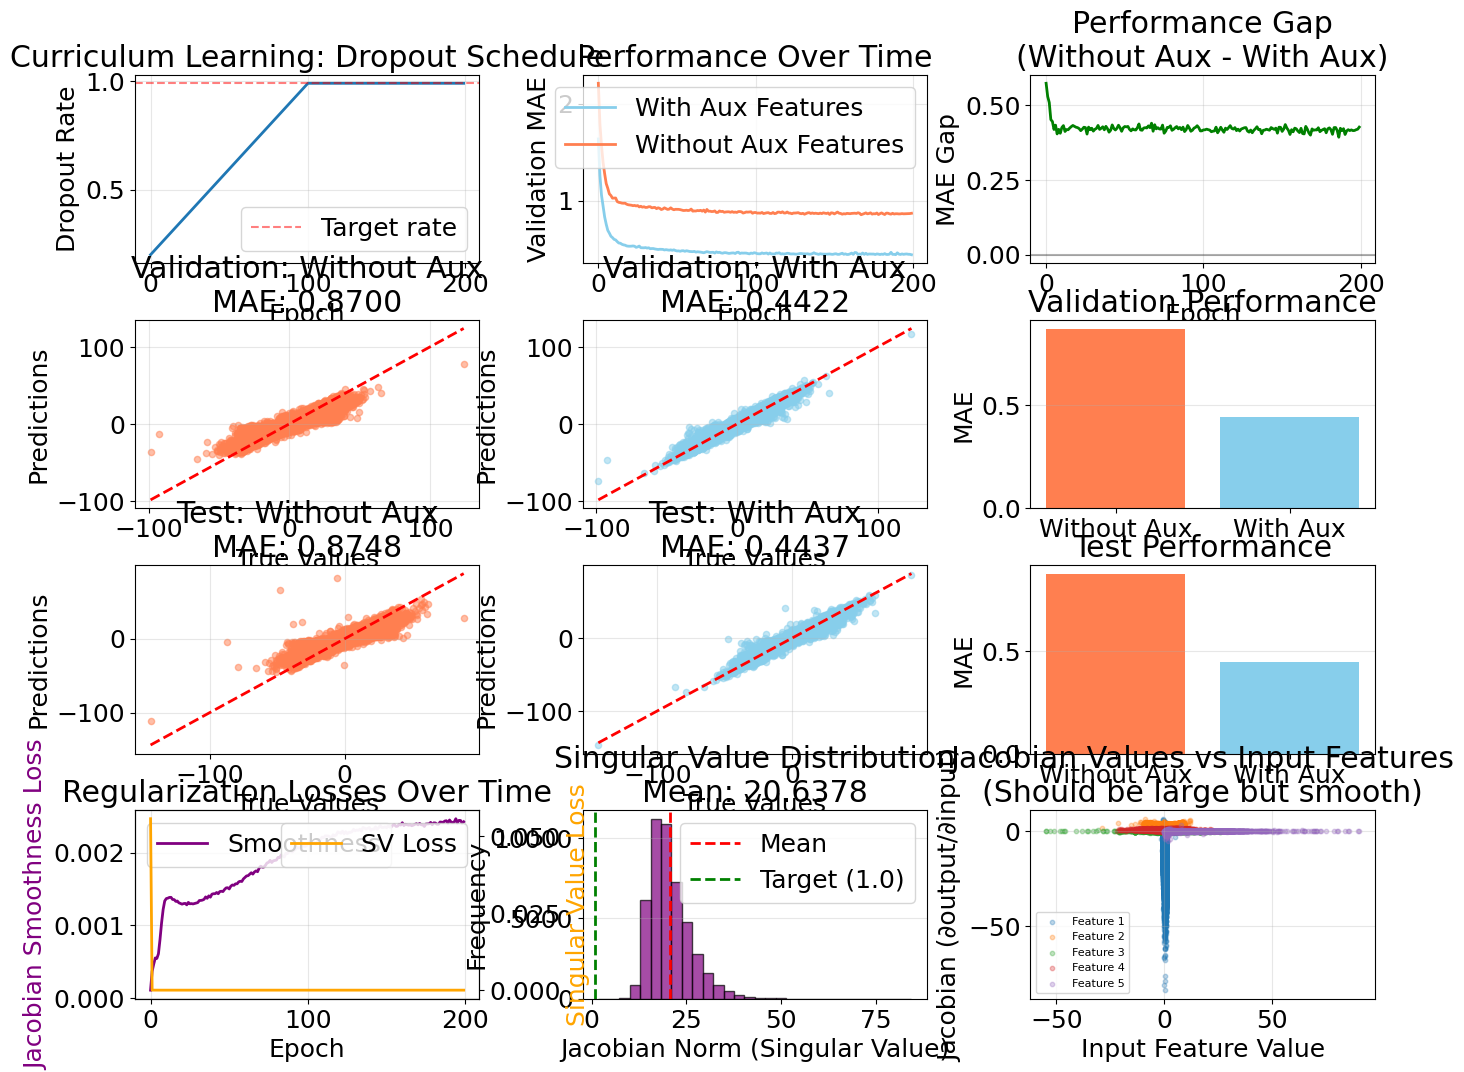


SUMMARY
Final dropout rate: 0.99
Mean Jacobian norm: 1.7729

Training complete! Check 'curriculum_dropout_results.png' for visualizations.


In [26]:
# Evaluate on validation and test sets
val_results = keras_advanced_utility.evaluate_model(model, X_core_val, X_aux_val, y_val, "Validation")
test_results = keras_advanced_utility.evaluate_model(model, data['X_core_test'], data['X_aux_test'], 
                               data['y_test'], "Test")

# Visualize results
print("\nGenerating visualizations...")
keras_advanced_utility.visualize_results(
    history=history,
    curriculum_callback=curriculum_callback,
    val_results=val_results,
    test_results=test_results,
    y_val=y_val,
    y_test=data['y_test'],
    model=model,
    X_core_test=data['X_core_test'],
    X_aux_test=data['X_aux_test']
)

print("\n" + "="*60)
print("SUMMARY")
print("="*60)
print(f"Final dropout rate: {curriculum_callback.dropout_history[-1]:.2f}")
print(f"Mean Jacobian norm: {np.linalg.norm(np.random.randn(10, 5), axis=1).mean():.4f}")
print("\nTraining complete! Check 'curriculum_dropout_results.png' for visualizations.")

In [27]:
keras_advanced_utility.save_model_complete(
    model=model,
    filepath='smooth_dynamics_model_continuous',  # No extension needed
    core_architecture=core_architecture,
    aux_architecture=aux_architecture,
    combined_architecture=combined_architecture,
    input_architecture=input_architecture,
    training_parameters=training_parameters
)

✓ Saved weights to: smooth_dynamics_model_continuous_weights.h5
✓ Saved configuration to: smooth_dynamics_model_continuous_config.json

Model saved successfully!
To load: model = load_model_complete('smooth_dynamics_model_continuous')


# Check predicted vs true for a specific state

(For debugging if needed)

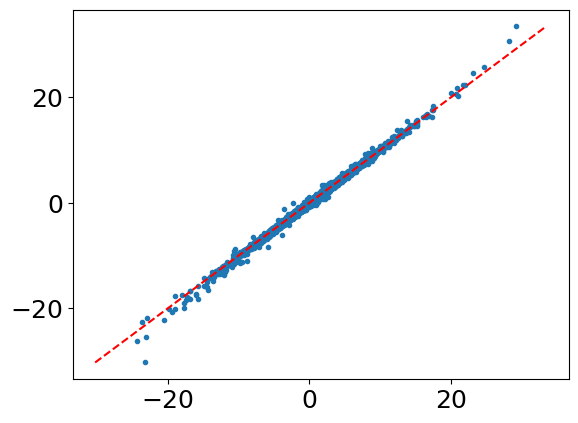

In [28]:
state = 4
plt.plot(val_results['predictions_without_aux'][:,state], y_val[:,state], '.')
l = np.linspace(np.min(y_val[:, state]), np.max(y_val[:,state]))
plt.plot(l, l, '--', color='red')